In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import json

import cmocean.cm as cmo
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import ticker
from shapely import Polygon
import cv2
import scipy.optimize as optimize
from sklearn.metrics import r2_score

import flim_processing as fp
import flim_analysis as fa
import flim_geometry as fg
from ivium import IviumFile

mass_particle_AC = 0.35e-6
radius_particle_AC = 454.5e-6
surface_area_AC = 2.6e-6
volume_AC = 39.46e-9
diff_OH = 5.270e-9
area_channel = 4e-3**2
nu_water = 1e-6
pixel_size = 9.09e-6

In [2]:
data_folder = r"D:\[Code]\paper01\data"
figures_folder = r"D:\[Code]\paper01\figures"

In [3]:
"""FLIM data"""
time_data = fp.open_flim(
    os.path.join(data_folder, "time_p.npz"),
    property_modifications={"lifetime_phase": 1000, "value": 1000},
)

"""Features"""
time_features = fg.load_features(data_folder, "time_features.shp", "time_features.npz")

"""Open flim .json"""
with open(os.path.join(data_folder, "time.json"), "r") as file:
    time_info = json.load(file)
timestamps_flim = np.array(list(time_info["FLIMIMAGE"]["TIMESTAMPS in ms"].values()))
delta_t_flim = timestamps_flim[1] * 1e-3

"""Load Potential and Current data from ivium file"""
time_ivium = IviumFile()
time_ivium.set_path(os.path.join(data_folder, "time_ivium1428.csv"))
time_ivium.read_data_from_file()

"""Timestamps and frames"""
t_start = 30  # seconds
delta_t = 10  # seconds
t_eval = np.arange(t_start, 180, delta_t)
Fo_eval = (t_eval - t_start) * diff_OH / (2 * radius_particle_AC) ** 2

time_stamps = np.array([1000, 180, 240, 300, 360, 420, 480, 540, 600, 660])
flim_frames = flim_frames = fp.timestamp2frame_flim(t_eval, time_info, offset_flim=-5)[
    "flim_frames"
]

In [4]:
particle = [f for f in time_features if f.name == "particle"][0]
wall = [f for f in time_features if f.name == "wall"][0]
membrane = [f for f in time_features if f.name == "membrane"][0]

extent = fa.get_extent(time_data["value"][0], 9.09, 1e-3)
geom_extent = [
    0,
    time_data["intensity"][0].shape[1],
    0,
    time_data["intensity"][0].shape[0],
]

img_e_field = mpimg.imread(os.path.join(data_folder, "E-field.png"))

# Figure 01

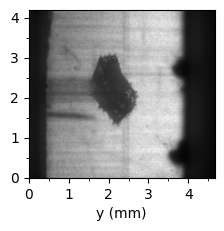

In [5]:
chosen_frame = 0

"""Open flim .json"""
fig, ax = plt.subplots(figsize=(2.4, 2.2))

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.set_xlabel("x (mm)")
ax.set_xlabel("y (mm)")

"""pH image"""
img = ax.imshow(
    time_data["intensity"][flim_frames[chosen_frame]],
    cmap="gray",
    extent=extent,
)

"""Drawing Features"""
# ax.imshow(particle.transparent_mask, extent=extent, cmap="gray")
# gpd.GeoSeries(
#    fp.affine_transform_pixel2extent(membrane.geometry, geom_extent, list(extent))
# ).exterior.plot(ax=ax, color="black", lw=1)
# gpd.GeoSeries(
#    fp.affine_transform_pixel2extent(wall.geometry, geom_extent, list(extent))
# ).exterior.plot(ax=ax, color="black", lw=1)

fig.savefig(os.path.join(figures_folder, "figure01_B.png"), dpi=100)
plt.show()

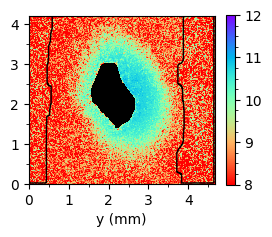

In [6]:
chosen_frame = 6

"""Open flim .json"""
fig, ax = plt.subplots(figsize=(3, 2.2))

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

ax.set_xlabel("x (mm)")
ax.set_xlabel("y (mm)")

"""pH image"""
img = ax.imshow(
    time_data["value"][flim_frames[chosen_frame]],
    vmin=8,
    vmax=12,
    cmap="rainbow_r",
    extent=extent,
)

"""Drawing Features"""
ax.imshow(particle.transparent_mask, extent=extent, cmap="gray")
gpd.GeoSeries(
    fp.affine_transform_pixel2extent(membrane.geometry, geom_extent, list(extent))
).exterior.plot(ax=ax, color="black", lw=1)
gpd.GeoSeries(
    fp.affine_transform_pixel2extent(wall.geometry, geom_extent, list(extent))
).exterior.plot(ax=ax, color="black", lw=1)

clb = fig.colorbar(img, ax=ax)
clb.ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
clb.ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))

fig.savefig(os.path.join(figures_folder, "figure01_C.png"), dpi=100)
plt.show()

# Figure 02

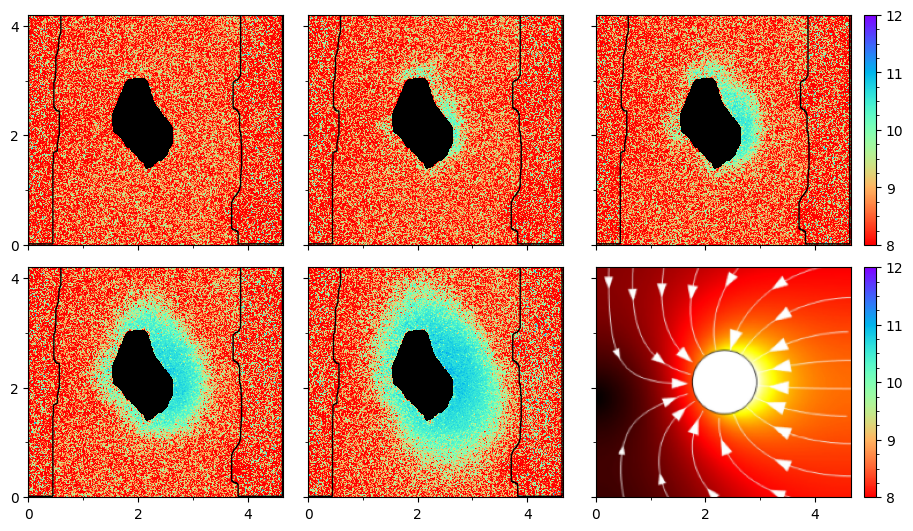

In [8]:
ncols = 3
nrows = 2

fig, axes = plt.subplots(
    nrows, ncols, sharex=True, sharey=True, figsize=(9, 5.2), layout="constrained"
)
axes.flat[0].xaxis.set_major_locator(ticker.MultipleLocator(2))
axes.flat[0].yaxis.set_major_locator(ticker.MultipleLocator(2))
axes.flat[0].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
axes.flat[0].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

chosen_flim_frames = [
    flim_frames[i] for i in range(len(flim_frames)) if i in [0, 1, 2, 4, 7]
]
chosen_t_eval = [t_eval[i] for i in range(len(flim_frames)) if i in [0, 1, 2, 4, 7]]
for i in range((ncols * nrows) - 1):
    ax = axes.flat[i]

    """pH image"""
    img = ax.imshow(
        time_data["value"][chosen_flim_frames[i]],
        vmin=8,
        vmax=12,
        cmap="rainbow_r",
        extent=extent,
    )

    """Drawing Features"""
    ax.imshow(particle.transparent_mask, extent=extent, cmap="gray")
    gpd.GeoSeries(
        fp.affine_transform_pixel2extent(membrane.geometry, geom_extent, list(extent))
    ).exterior.plot(ax=ax, color="black", lw=1)
    gpd.GeoSeries(
        fp.affine_transform_pixel2extent(wall.geometry, geom_extent, list(extent))
    ).exterior.plot(ax=ax, color="black", lw=1)

clb = fig.colorbar(img, ax=axes.flat[2])
# clb.set_label("pH", labelpad=-30, y=1.06, rotation=0)
clb.ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
clb.ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))

clb = fig.colorbar(img, ax=axes.flat[-1])
# clb.set_label("pH", labelpad=-30, y=1.06, rotation=0)
clb.ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
clb.ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))


ax = axes.flat[-1]
ax.imshow(img_e_field, extent=extent)
fig.savefig(os.path.join(figures_folder, "figure02.pdf"), dpi=100)
plt.show()